FieldNBalance is a program that estimates the N balance and provides N fertilizer recommendations for cultivated crops.
Author: Hamish Brown.
Copyright (c) 2024 The New Zealand Institute for Plant and Food Research Limited

In [70]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

CBcolors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

In [71]:
try: 
    if os.environ["GITHUB_WORKSPACE"] != None:
        root = os.environ["GITHUB_WORKSPACE"]
        inPath = os.path.join(root, "TestComponents", "TestSets", "WS2")
        outPath = os.path.join(root, "TestGraphs", "Outputs") 
        localDayFirst = False
        localDateFormat = '%m/%d/%Y %H:%M:%S'
except: 
    localDayFirst = True
    localDateFormat = '%d/%m/%Y %H:%M:%S %p'
    rootfrags = os.path.abspath('WS2.py').split("\\")
    root = ""
    for d in rootfrags:
        if d == "FieldNBalance":
            break
        else:
            root += d + "\\"
    inPath = os.path.join(root,"FieldNBalance","TestComponents", "TestSets", "WS2")
    outPath = os.path.join(root,"FieldNBalance","TestGraphs", "Outputs")   

In [72]:
Configs = pd.read_pickle(os.path.join(inPath, "FieldConfigs.pkl"))

In [73]:
observedCrop = pd.read_csv(os.path.join(inPath, "CropData.csv"), index_col=0)
observedCrop.sort_index(axis=0,inplace=True)
observedCrop['Date'] = pd.to_datetime(observedCrop['Date'],dayfirst=True)

In [74]:
observedSoil = pd.read_csv(os.path.join(inPath, "SoilData.csv"),index_col=0)
observedSoil.sort_index(axis=0,inplace=True)
observedSoil['Date'] = pd.to_datetime(observedSoil['Date'],dayfirst=True)
observedSoil['SoilMineralN'] = observedSoil.loc[:,['SoilN0_15', 'SoilN15_30']].sum(axis=1)

In [75]:
testFiles = []
tests = []
for file in os.listdir(os.path.join(inPath,"Outputs")):
    if file.endswith('.csv'):
        testFiles.append(file)
        tests.append(file.replace(".csv",""))

In [76]:
Alltests =[]
for t in testFiles[:]:  
    testframe = pd.read_csv(os.path.join(inPath, "Outputs", t),index_col=0,dayfirst=localDayFirst,date_format=localDateFormat)  
    Alltests.append(testframe)   

AllData = pd.concat(Alltests,axis=1,keys=tests)
AllData.sort_index(axis=0,inplace=True)
AllData.index = pd.to_datetime(AllData.index)

In [77]:
TestsFrame = pd.DataFrame(index = [int(x[0]) for x in tests],data=tests,columns = ['crop'])
TestsFrame.index.name = 'Site'

In [78]:
ObsPredIndex = pd.MultiIndex.from_product([tests,AllData.index],names=['Treatment','Date'])
ObsPredCropN = pd.DataFrame(index = ObsPredIndex, columns = ['obs','pred'])
ObsPredCropN.loc[:,'Site'] =  [int(ObsPredIndex[x][0][0]) for x in range(ObsPredIndex.size)]
ObsPredCropN.set_index('Site',append=True,inplace=True)
ObsPredCropN = ObsPredCropN.reorder_levels(['Site','Treatment','Date'],axis=0)
ObsPredCropN = ObsPredCropN.sort_index()

In [79]:
ObsCropN = observedCrop.loc[:,['Date','CropN']]
ObsCropN.loc[:,'Date'] = [(ObsCropN.iloc[x,0] + dt.timedelta(hours=12)) for x in range(ObsCropN.index.size)]
ObsCropN.set_index('Date',append=True,inplace=True)
ObsCropN.columns = ['obs']
ObsCropN = ObsCropN.groupby(['Site','Date']).mean()
for t in tests:
    s = int(t[0])
    obs = ObsCropN.loc[s,:]
    obs.sort_index(inplace=True)
    dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
    Pred = AllData.loc[dates,(t,'CropN')]
    pred = Pred.reindex(obs.index.values)
    pred.sort_index(axis=0, inplace=True)
    for d in obs.index.values:
        ObsPredCropN.loc[(s,t,d),'pred'] = pred[d]
        ObsPredCropN.loc[(s,t,d), 'obs'] = obs.loc[d,'obs']

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_2388\2460292921.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  Obs = ObsPredCropN.loc[s,'obs']
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_2388\2460292921.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  Pred = ObsPredCropN.loc[s,'pred']
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_2388\2460292921.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  maxval = max(ObsPredCropN.loc[s,'obs'].max(),ObsPredCropN.loc[s,'pred'].max()) * 1.05


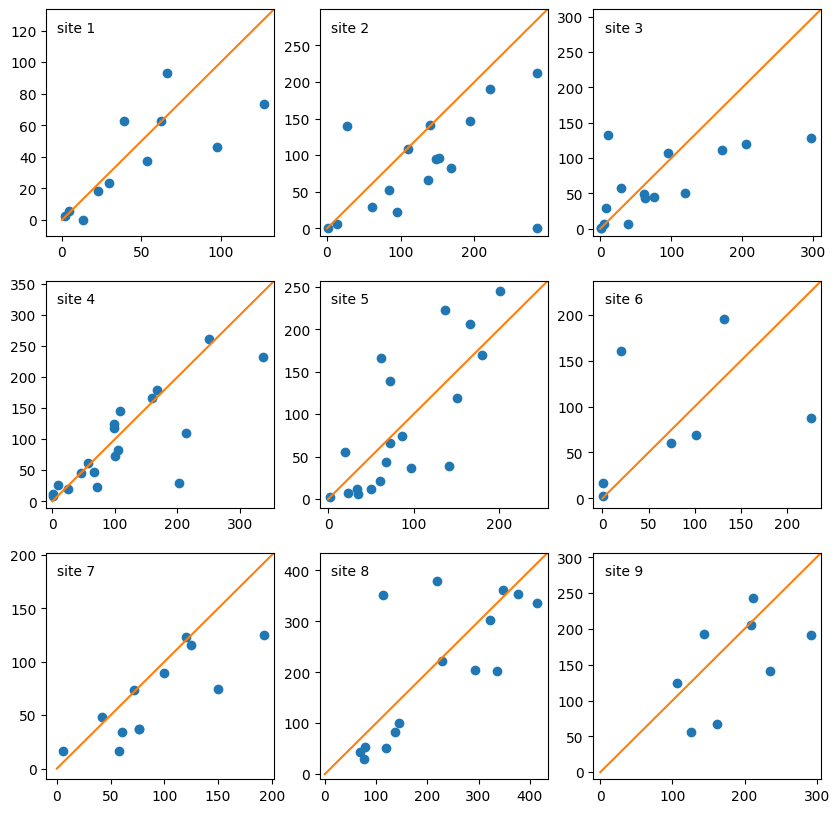

In [80]:
graph = plt.figure(figsize=(10,10))
pos = 1
for s in range(1,10):
    Obs = ObsPredCropN.loc[s,'obs']
    Pred = ObsPredCropN.loc[s,'pred']
    #RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
    ax = graph.add_subplot(3,3,pos)
    plt.plot(Obs,Pred,'o')
    maxval = max(ObsPredCropN.loc[s,'obs'].max(),ObsPredCropN.loc[s,'pred'].max()) * 1.05
    plt.ylim(-10,maxval)
    plt.xlim(-10,maxval)
    plt.plot([0,maxval],[0,maxval],'-')
    plt.text(0.05,0.9,'site '+str(s),transform = ax.transAxes)
    #plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
    pos +=1

Text(0.5, 0, 'Observed')

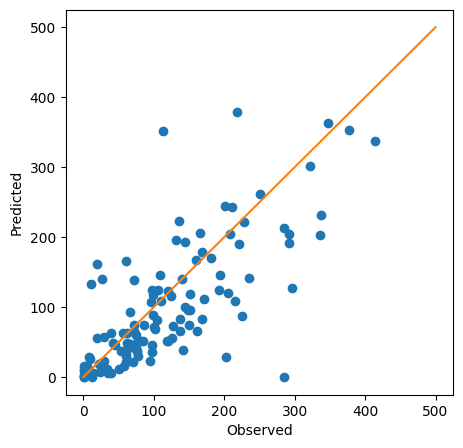

In [81]:
Obs = ObsPredCropN.obs.values
Pred = ObsPredCropN.pred.values
graph = plt.figure(figsize = (5,5))
ax = graph.add_subplot(1,1,1)
plt.plot(Obs,Pred,'o')
plt.plot([0,500],[0,500],'-')
#RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
#plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
plt.ylabel('Predicted')
plt.xlabel('Observed')

In [82]:
ObsSoilN = observedSoil.loc[:,['Date','SoilMineralN']]
ObsSoilN.loc[:,'Date'] = [(ObsSoilN.iloc[x,0] + dt.timedelta(hours=12)) for x in range(ObsSoilN.index.size)]
ObsSoilN.set_index('Date',append=True,inplace=True)
ObsSoilN.columns = ['obs']
ObsSoilN = ObsSoilN.groupby(['Site','Date']).mean()
blankIndex = pd.MultiIndex.from_product([[],[],[]], names = ['site','test','date'])
ObsPredSoilN = pd.DataFrame(index = blankIndex, columns = ['obs','pred'])
for t in tests:
    s = int(t[0])
    obs = ObsSoilN.loc[s,:]
    dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'SoilMineralN')].index
    Pred = AllData.loc[dates,(t,'SoilMineralN')]
    pred = Pred.reindex(obs.index.values)
    for d in obs.index.values:
        ObsPredSoilN.loc[(s,t,d),'pred'] = pred[d]
        ObsPredSoilN.loc[(s,t,d), 'obs'] = obs.loc[d,'obs']

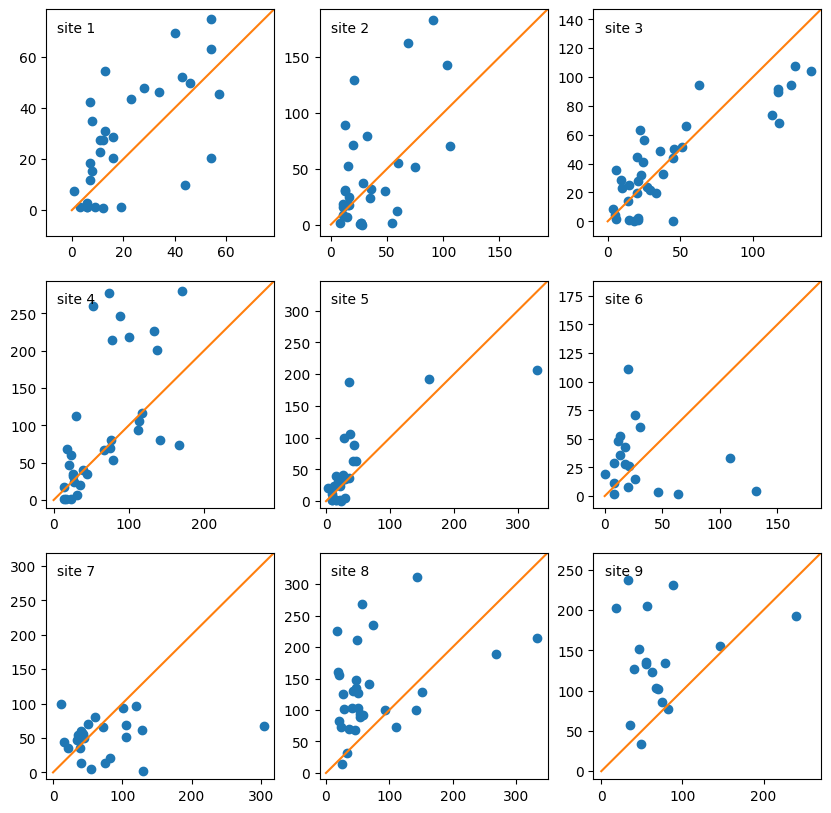

In [83]:
graph = plt.figure(figsize=(10,10))
pos = 1
for s in range(1,10):
    Obs = ObsPredSoilN.loc[s,'obs']
    Pred = ObsPredSoilN.loc[s,'pred']
    #RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
    ax = graph.add_subplot(3,3,pos)
    plt.plot(Obs,Pred,'o')
    maxval = max(ObsPredSoilN.loc[s,'obs'].max(),ObsPredSoilN.loc[s,'pred'].max()) * 1.05
    plt.ylim(-10,maxval)
    plt.xlim(-10,maxval)
    plt.plot([0,maxval],[0,maxval],'-')
    plt.text(0.05,0.9,'site '+str(s),transform = ax.transAxes)
    #plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
    pos +=1

Text(0.5, 0, 'Observed')

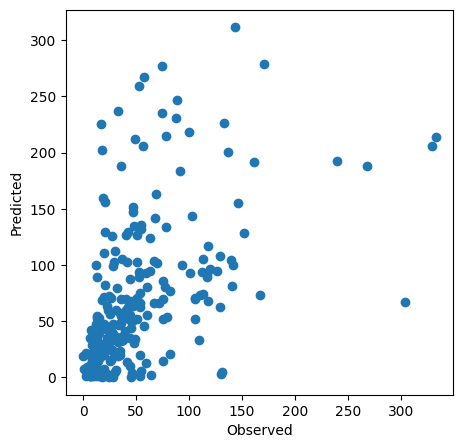

In [84]:
Obs = ObsPredSoilN.obs.values
Pred = ObsPredSoilN.pred.values
graph = plt.figure(figsize = (5,5))
ax = graph.add_subplot(1,1,1)
plt.plot(Obs,Pred,'o')
#RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
#plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
plt.ylabel('Predicted')
plt.xlabel('Observed')

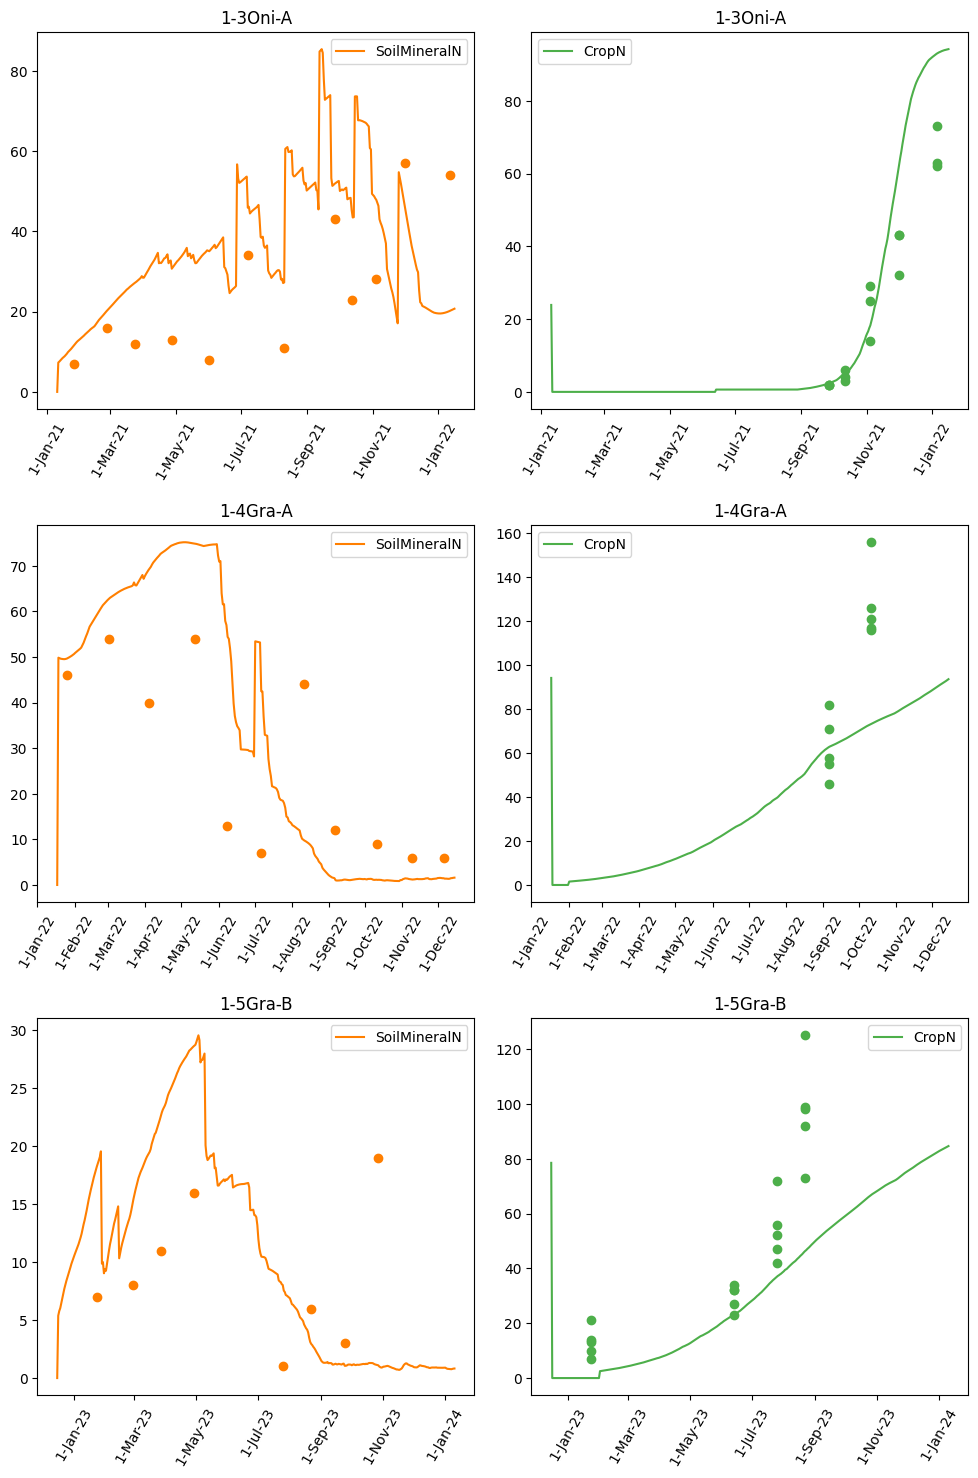

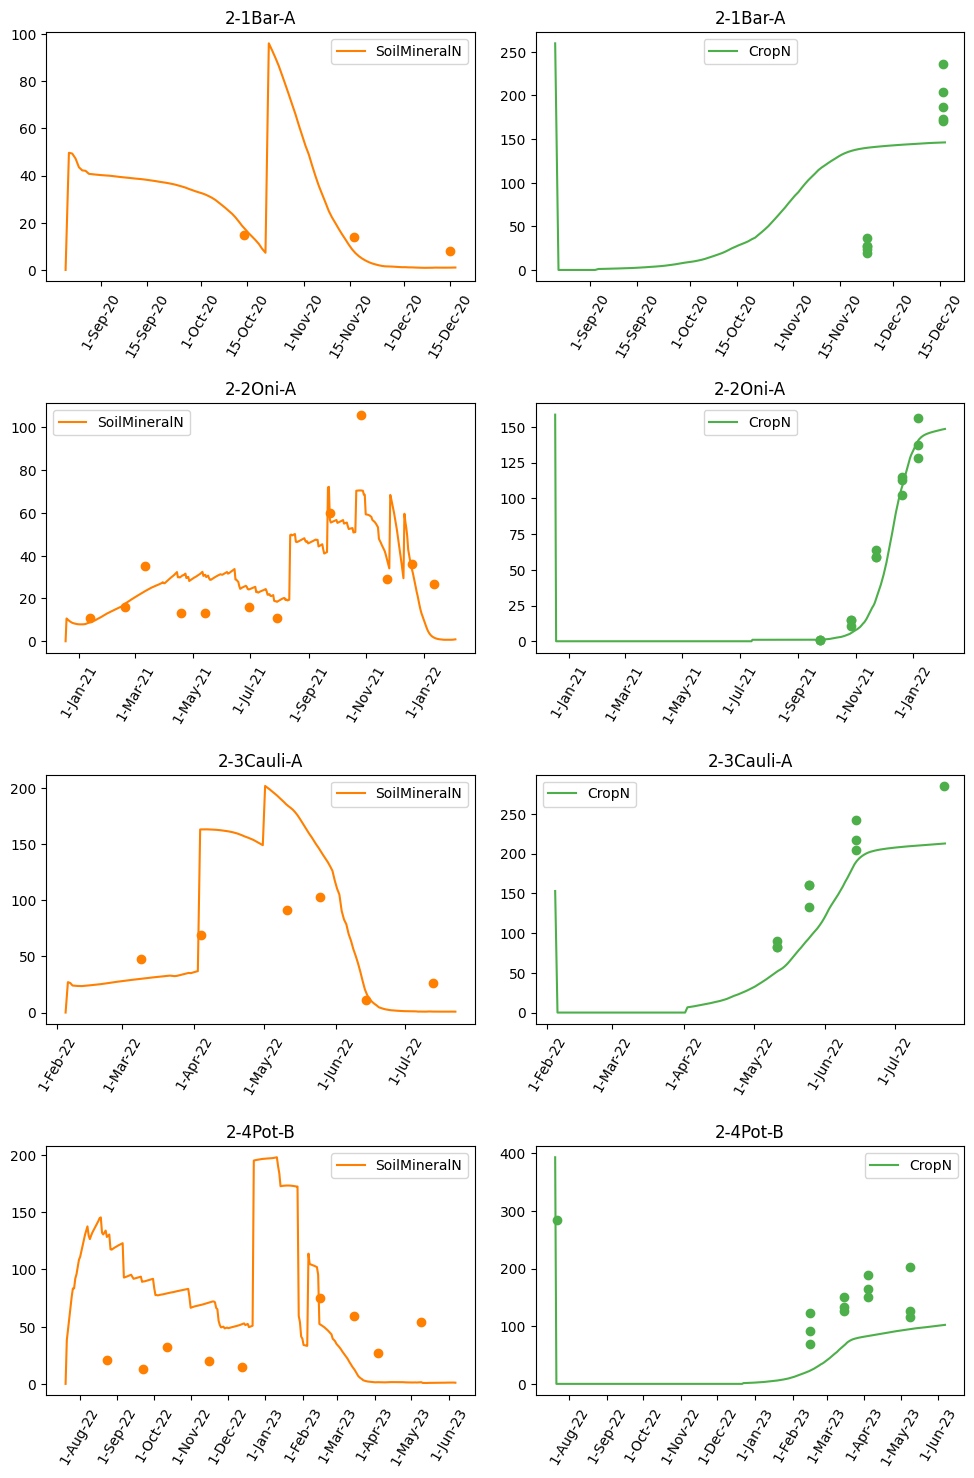

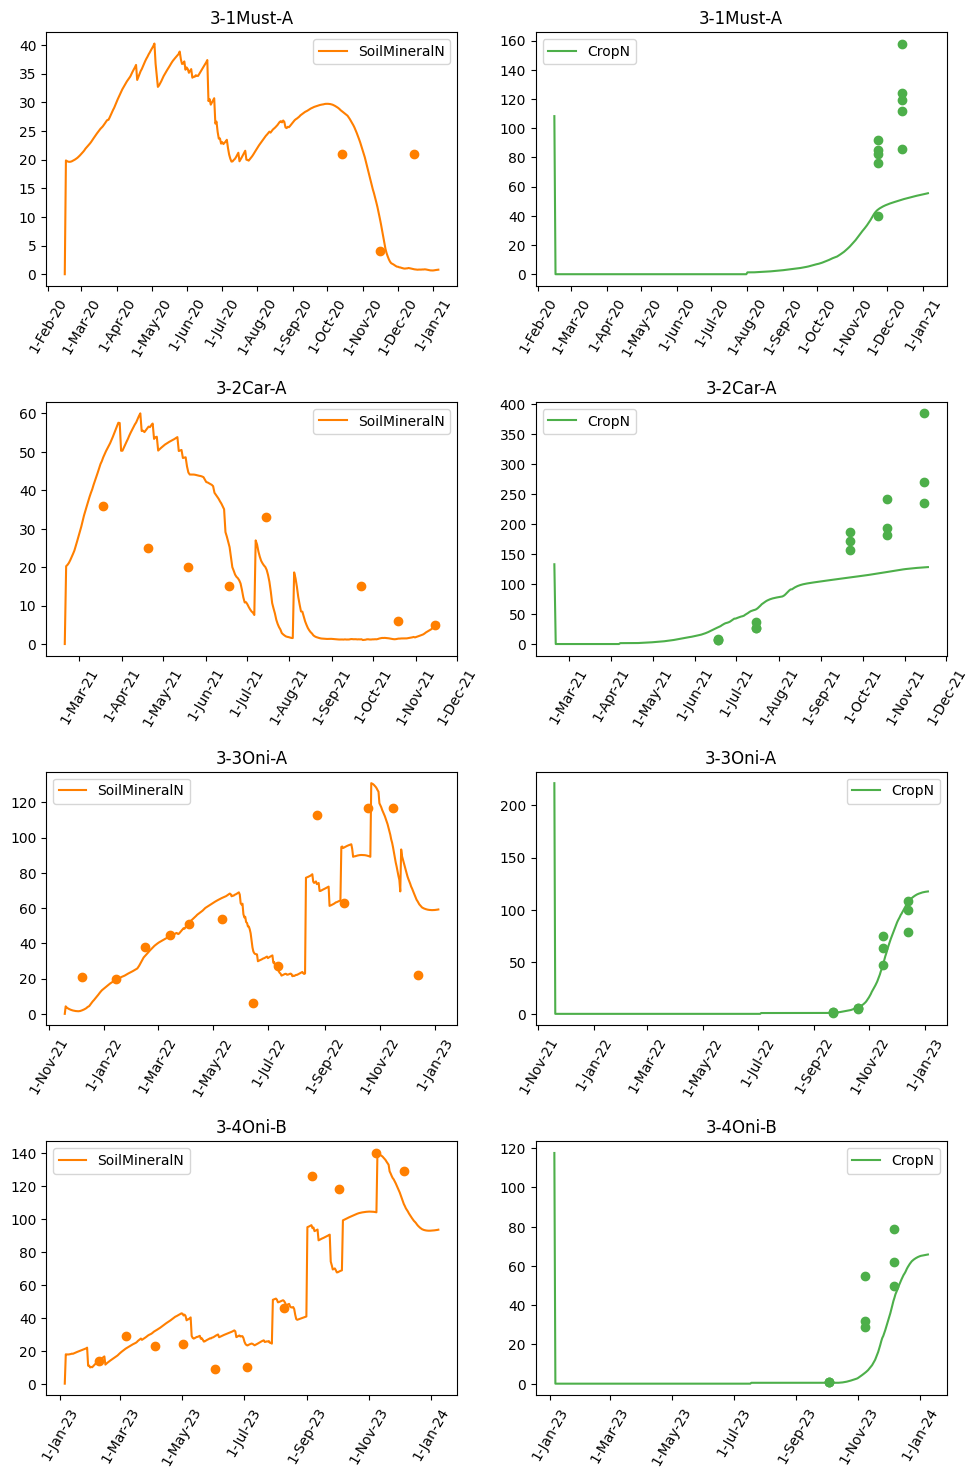

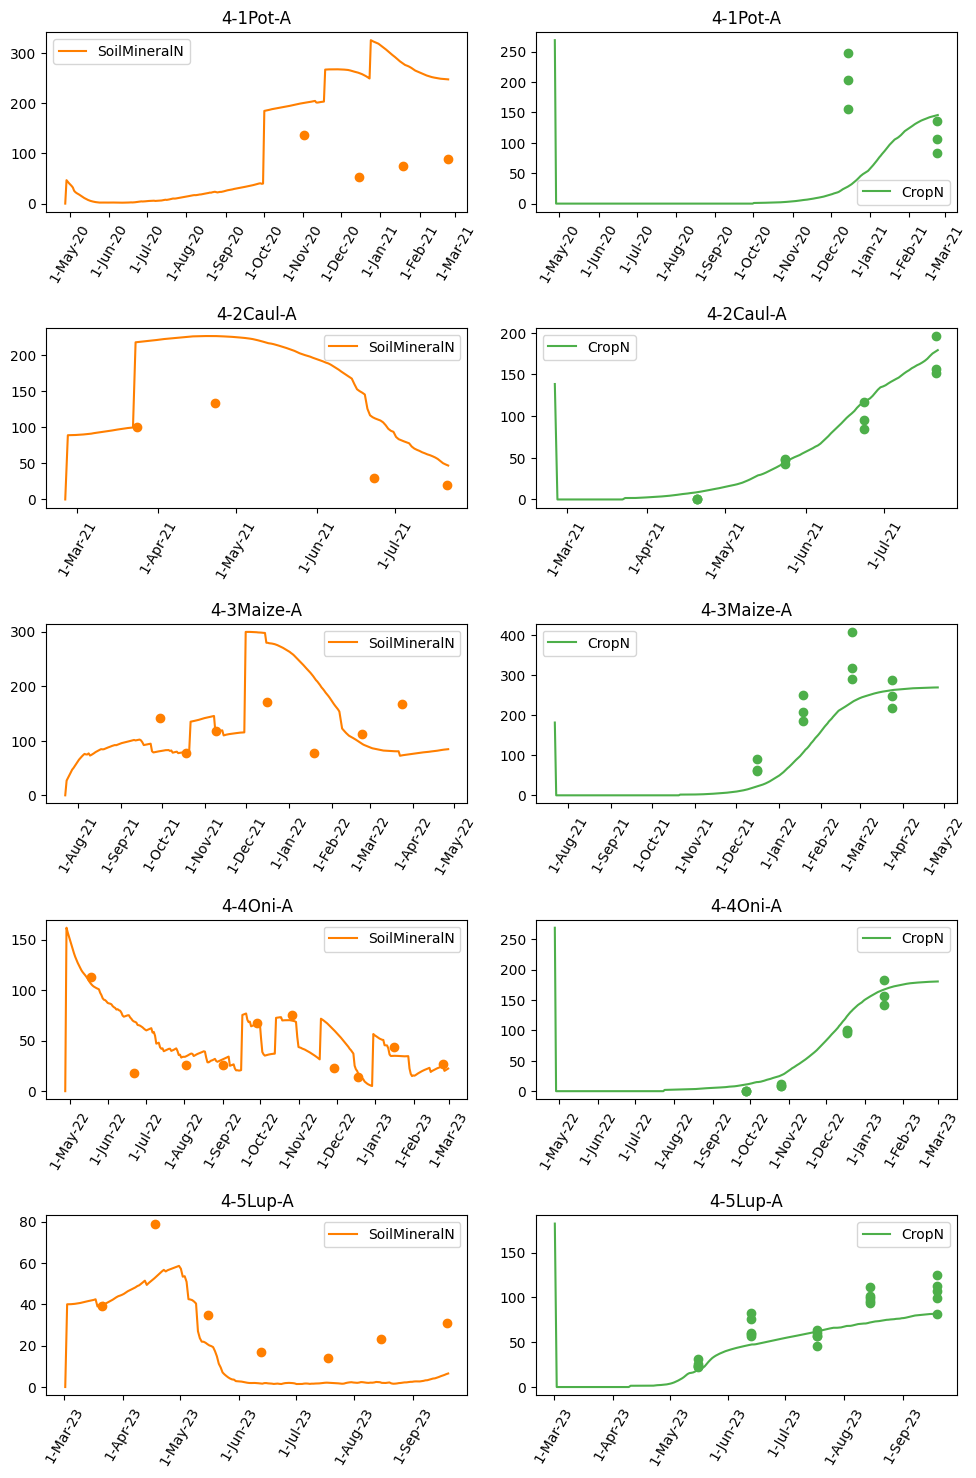

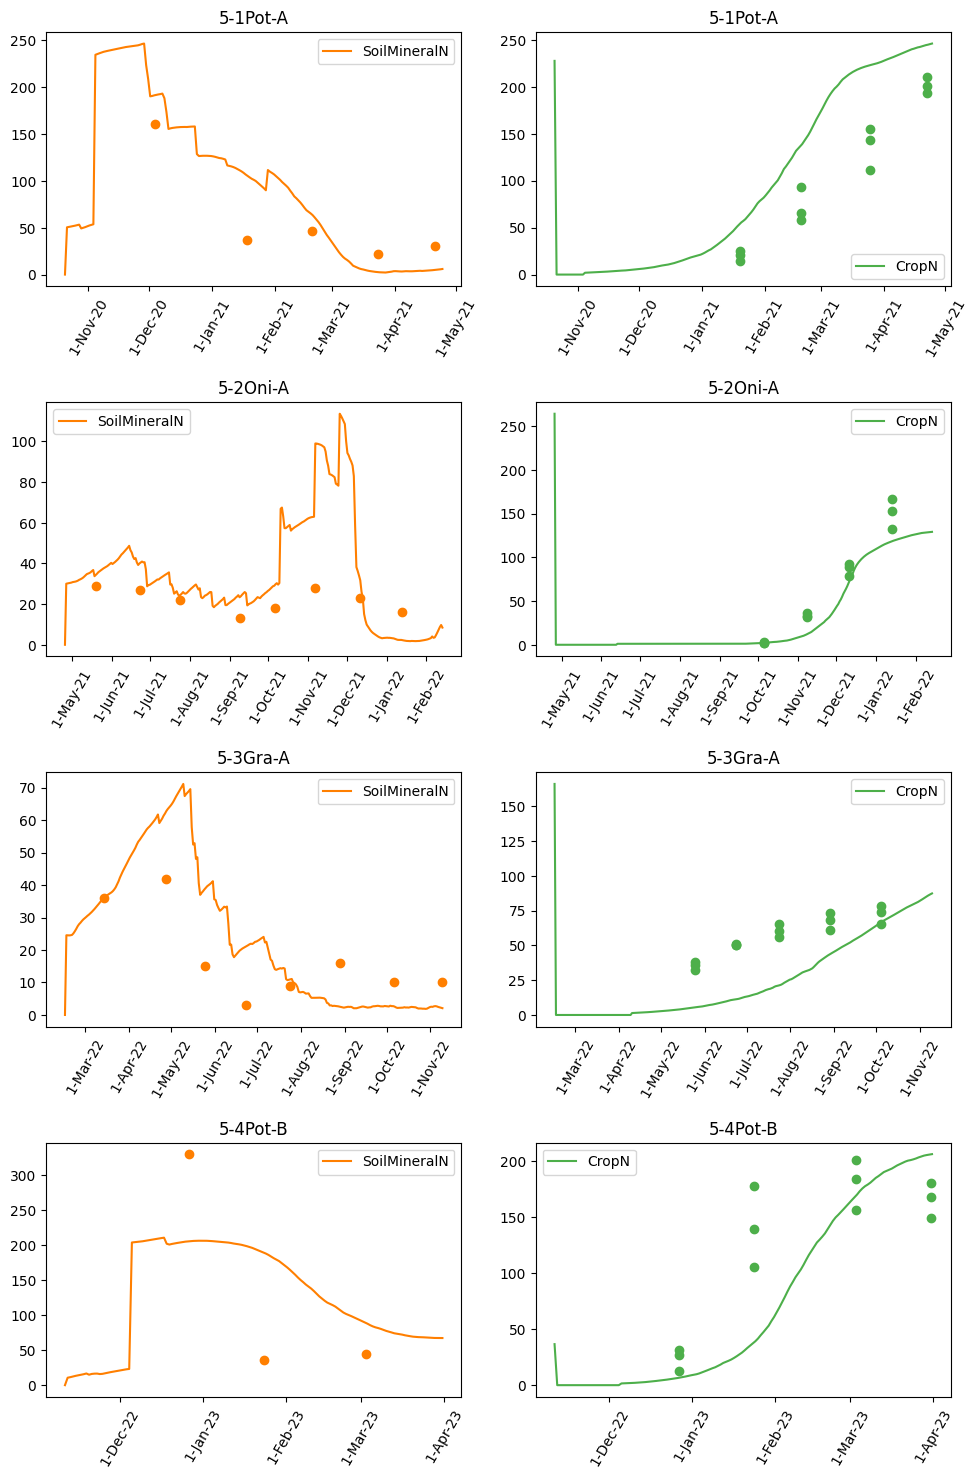

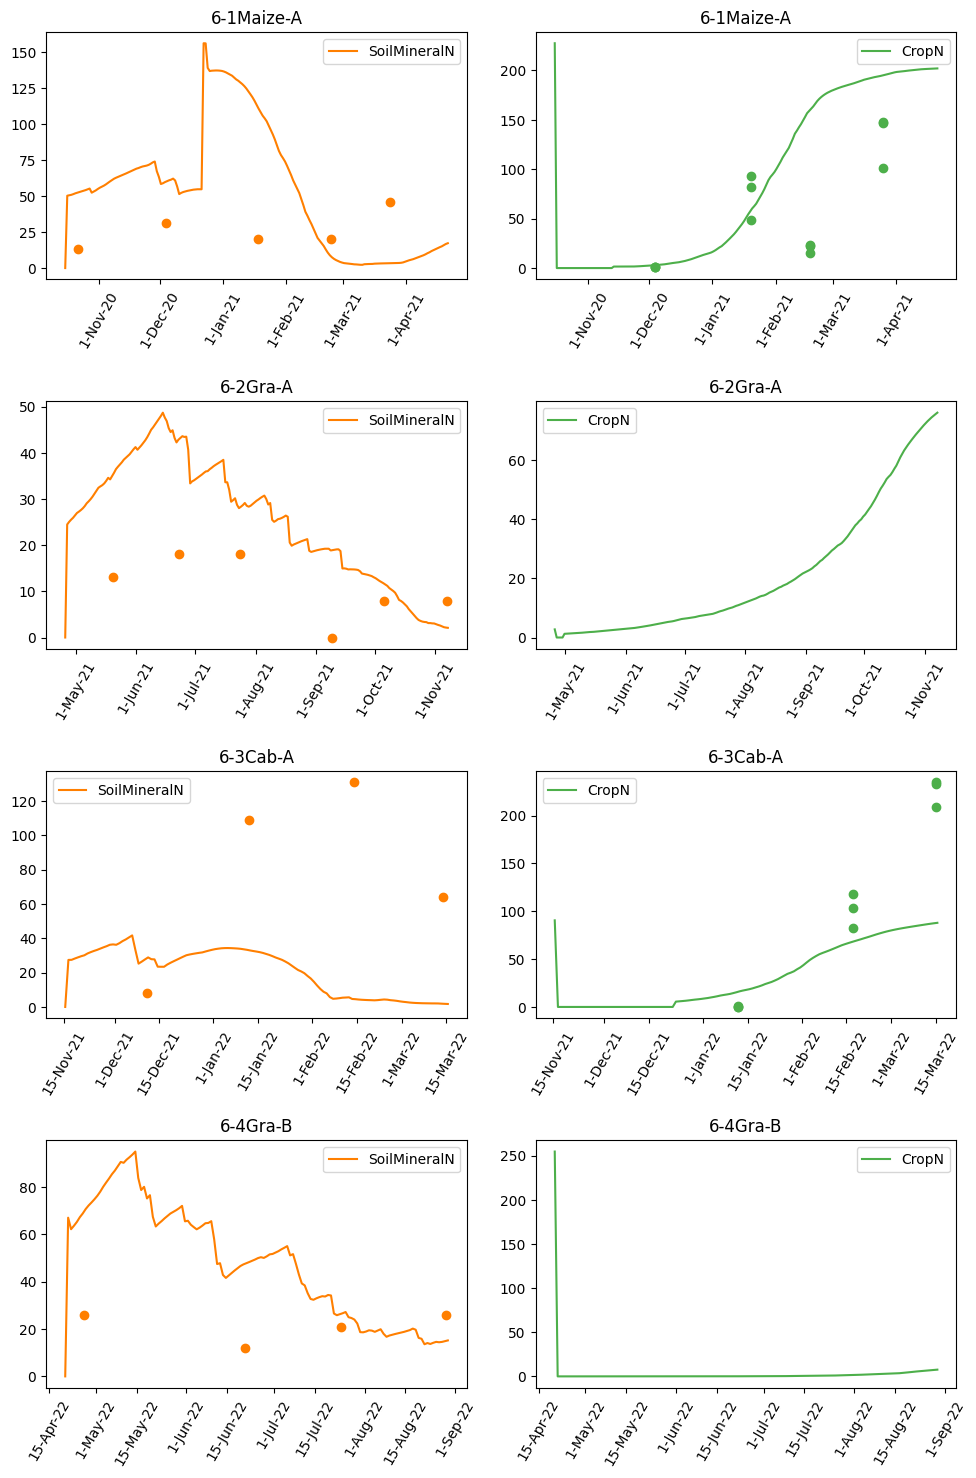

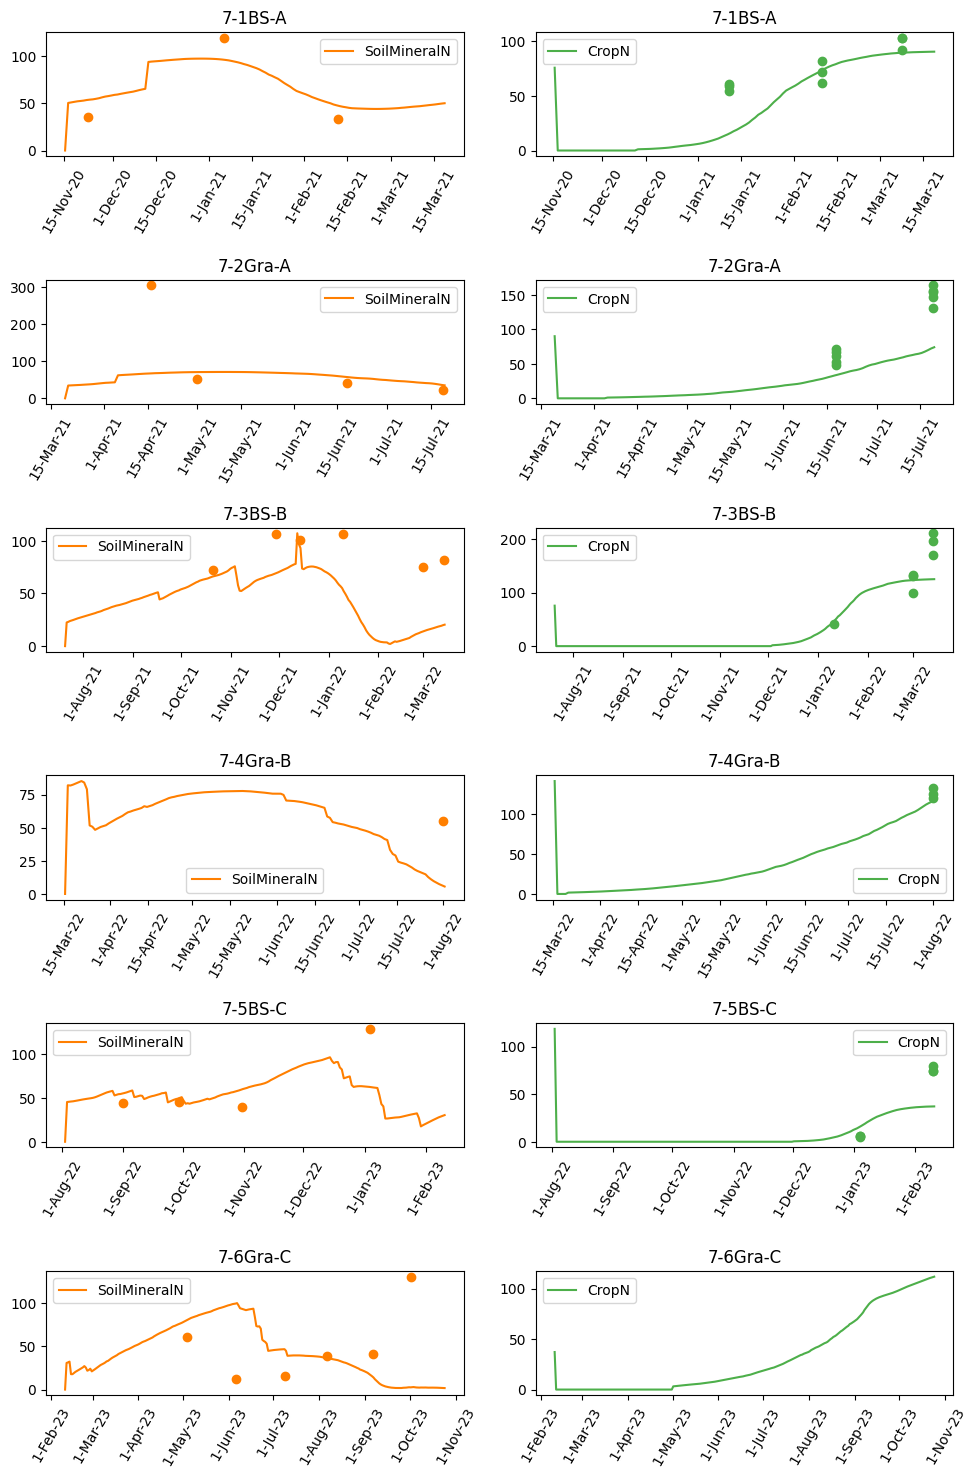

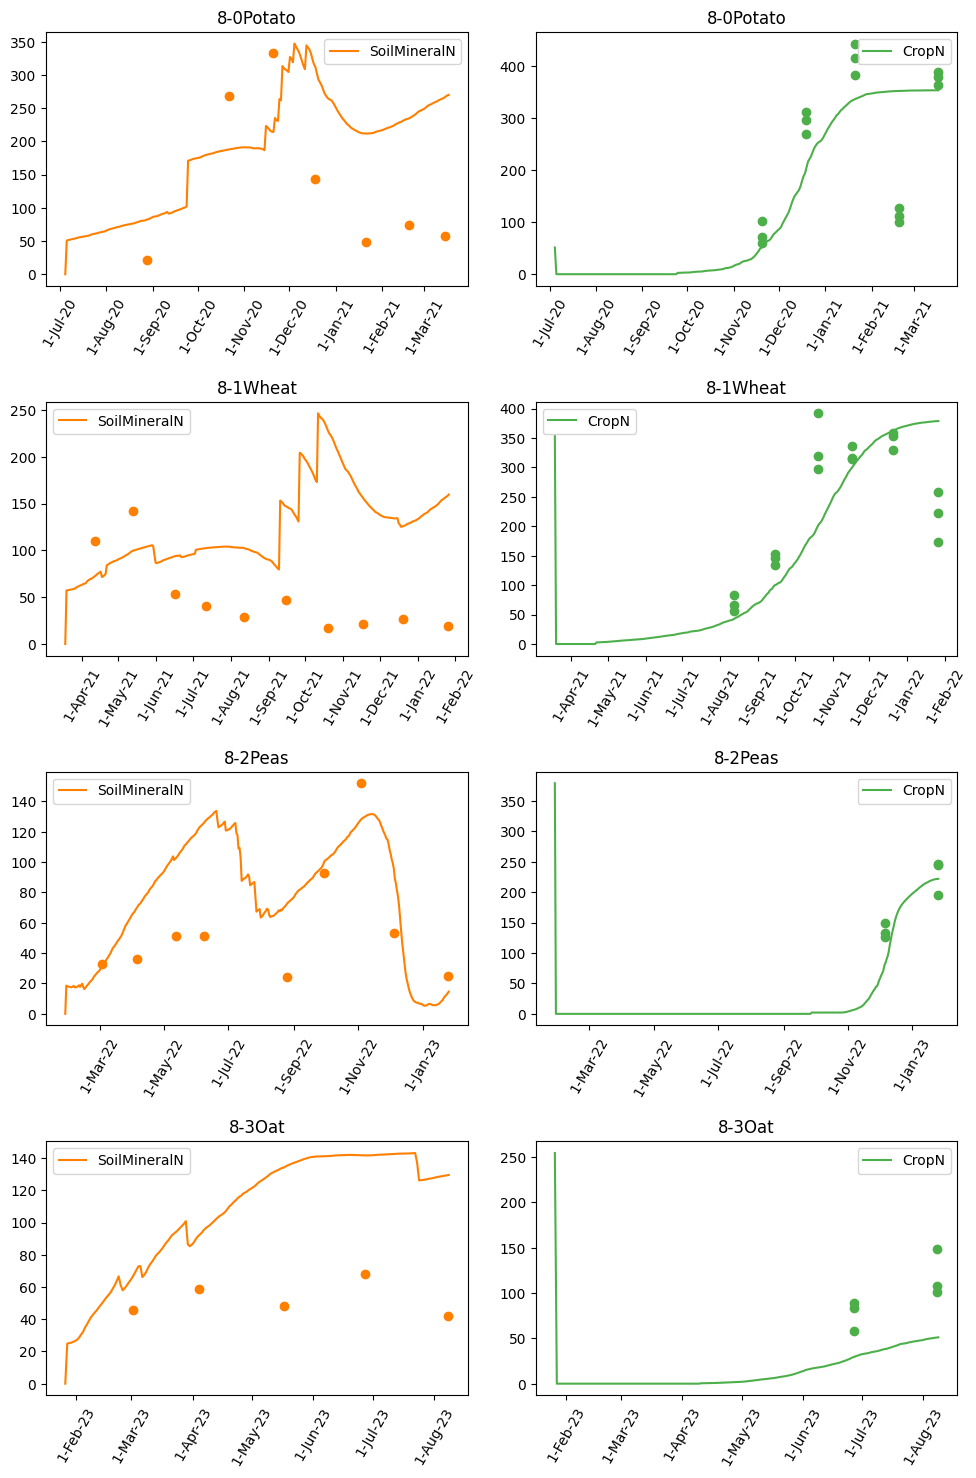

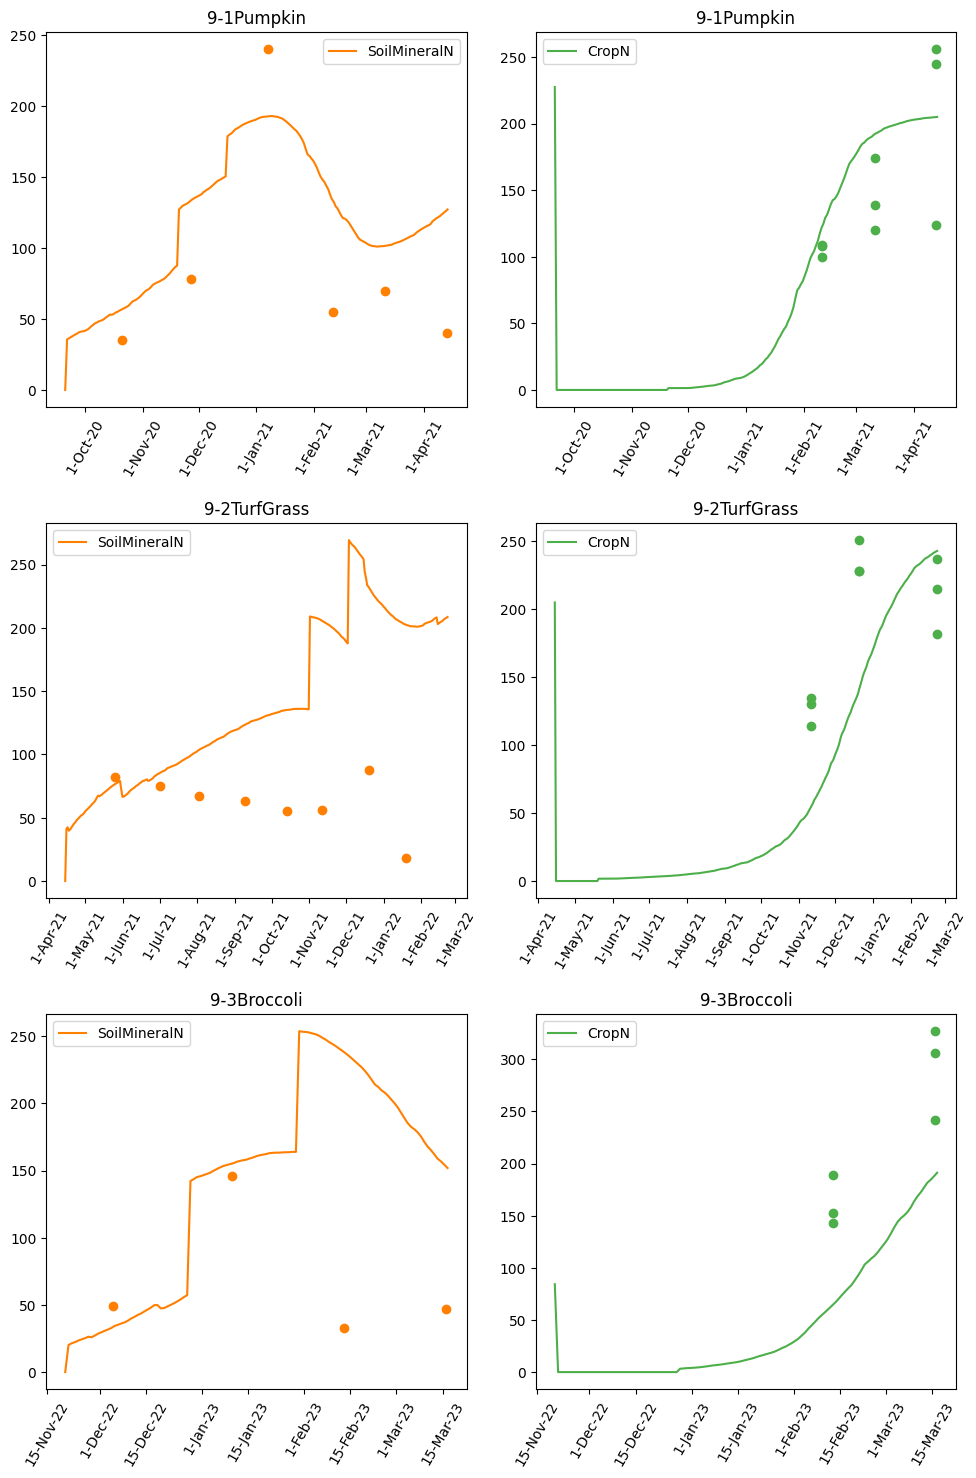

In [85]:
colors = ['orange','green']

for s in range(1,10):
    Graph = plt.figure(figsize=(10,15))
    testsAtSite = TestsFrame.loc[s,'crop'].values
    row_num=len(testsAtSite)
    pos = 1
    for t in testsAtSite: #['1Gra-A']:#tests:
        site = t[0]
        site = int(site)

        dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
        c = 0    
        for v in ['SoilMineralN','CropN']:
            ax = Graph.add_subplot(row_num,2,pos)
            Data = AllData.loc[dates,(t,v)]
            plt.plot(Data,color=CBcolors[colors[c]],label=v)

            if v == 'CropN':
                sData = observedCrop.loc[site,:]
            if v == 'SoilMineralN':
                sData = observedSoil.loc[site,:]
            dFilter = [dates.min() <= sData['Date'].iloc[x] <= dates.max() for x in range(len(sData['Date']))]
            plt.plot(sData.loc[dFilter,'Date'],sData.loc[dFilter,v],'o',color=CBcolors[colors[c]])

            plt.title(t)
            plt.xticks(rotation=60)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b-%y'))
            #plt.ylim(0,800)
            plt.legend()
            pos+=1
            c+=1
    Graph.tight_layout(pad=1.5)
    plt.savefig(os.path.join(outPath, "2-WS2 Site "+str(s) +".png"))

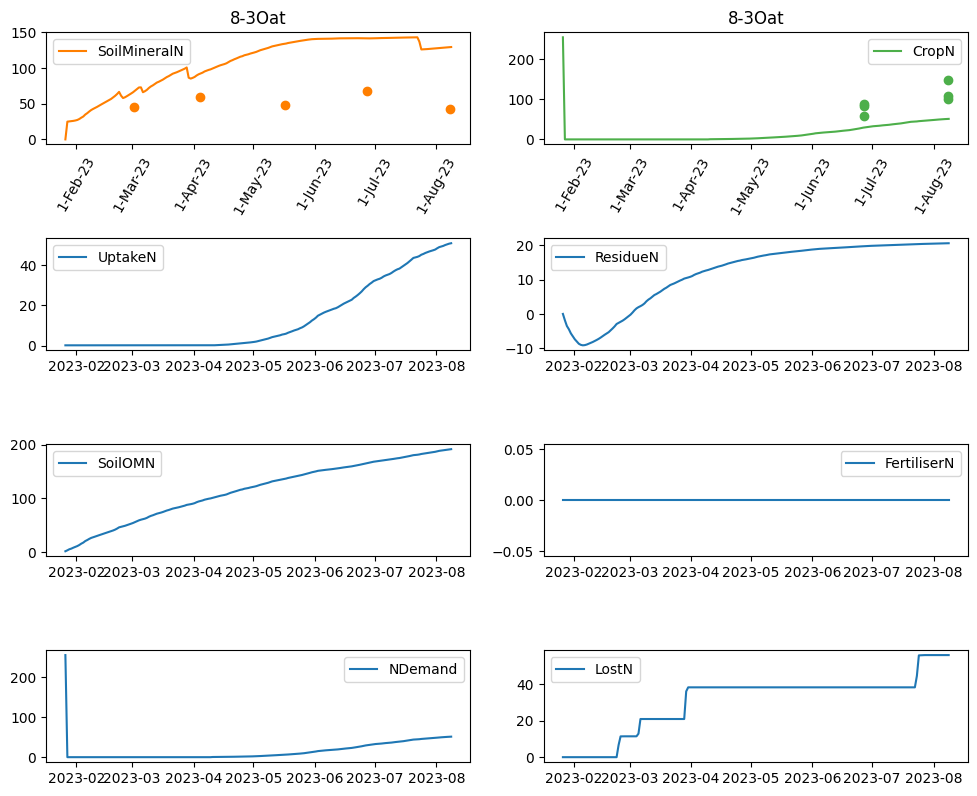

In [86]:
NbalComponents = ['UptakeN', 'ResidueN', 'SoilOMN', 'FertiliserN','NDemand','LostN']
accumulate = [True,True,True,True,False,True]
toAccumulate = dict(zip(NbalComponents,accumulate))

colors = ['orange','green']
Graph = plt.figure(figsize=(10,10))
pos = 1
row_num=len(tests)

t = '8-3Oat'
site = t[0]
site = int(site)

dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
c = 0    
for v in ['SoilMineralN','CropN']:
    ax = Graph.add_subplot(5,2,pos)
    Data = AllData.loc[dates,(t,v)]
    plt.plot(Data,color=CBcolors[colors[c]],label=v)

    if v == 'CropN':
        sData = observedCrop.loc[site,:]
    if v == 'SoilMineralN':
        sData = observedSoil.loc[site,:]
    dFilter = [dates.min() <= sData['Date'].iloc[x] <= dates.max() for x in range(len(sData['Date']))]
    plt.plot(sData.loc[dFilter,'Date'],sData.loc[dFilter,v],'o',color=CBcolors[colors[c]])

    plt.title(t)
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b-%y'))
    #plt.ylim(0,800)
    plt.legend()
    pos+=1
    c+=1
    
for nbc in NbalComponents:
    ax = Graph.add_subplot(5,2,pos)
    if toAccumulate[nbc] == False:
        Data = AllData.loc[dates,(t,nbc)]
    if toAccumulate[nbc] == True:
        Data = AllData.loc[dates,(t,nbc)].cumsum()
    plt.plot(Data,label=nbc)
    plt.legend()
    pos +=1
    
Graph.tight_layout(pad=1.5)
#plt.savefig(os.path.join(outPath, "TimeCourse.png"))